In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
import torch
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [3]:
# content_layers_default = []
#         style_layers_default = 

import torch
import torch.nn as nn
from torchvision.models import vgg19,VGG19_Weights
from collections import namedtuple

class myVgg19(nn.Module):
    def __init__(self,):
        super().__init__()

        vgg19model = vgg19(weights=VGG19_Weights.DEFAULT)
        vgg_pretrained_features = vgg19model.features

        self.features = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1','conv4_2', 'relu5_1']

        self.slice1 = nn.Sequential()
        self.slice2 = nn.Sequential()
        self.slice3 = nn.Sequential()
        self.slice4 = nn.Sequential()
        self.slice5 = nn.Sequential()
        self.slice6 = nn.Sequential()
        for x in range(2):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(2,7):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(7,12):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(12,21):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(21,22): # conv4 거치고 바로 뽑아냄. relu 전에
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        for x in range(22,30):
            self.slice6.add_module(str(x), vgg_pretrained_features[x])
            
        for param in self.parameters():
            param.requires_grad = False 
        

    def forward(self,x):
        relu1 = self.slice1(x)
        relu2 = self.slice2(relu1)
        relu3 = self.slice3(relu2)
        relu4 = self.slice4(relu3)
        conv4 = self.slice5(relu4)
        relu5 = self.slice6(conv4)

        vgg_outputs = namedtuple('VggOutputs',self.features)
        outputs = vgg_outputs(relu1,relu2,relu3,relu4,conv4,relu5)

        return outputs
        



In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

loss = torch.FloatTensor([0.0])

# 변환하려는 이미지 경로
content_image_path = './mount/My Drive/Colab Notebooks/GDLgon/data/neural_style_transfer/tubingen.jpg'
# 스타일 이미지 경로
style_reference_image_path = './mount/My Drive/Colab Notebooks/GDLgon/data/neural_style_transfer/starry-night.jpg'

# 생성된 사진의 차원
width, height,_ = cv.imread(content_image_path).shape
 # [768,1024,3]
img_columns = 600
img_rows = int(width * img_columns / height)

print(img_rows,img_columns)

def preprocess_image(image_path):
    img = cv.imread(image_path) #[h,w,c] BGR uint
    img = cv.resize(img,dsize=( img_columns,img_rows)) ##[w,h]순서인가? 
    plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    img = img /255.0
    #img_tensor = torch.cuda.FloatTensor(img).permute((0,3,1,2))
    img_tensor = torch.FloatTensor(img).permute((0,3,1,2))
    print(img_tensor.shape)
    #img = vgg19.preprocess_input(img)
    return img_tensor


450 600


torch.Size([1, 3, 450, 600])
torch.Size([1, 3, 450, 600])


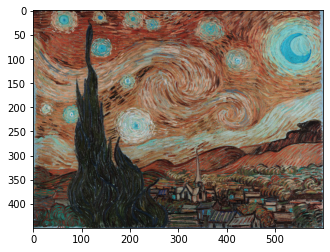

In [5]:
content_image = preprocess_image(content_image_path)  #[1,450, 600, 3] ->[1,3,450,600]
style_reference_image = preprocess_image(style_reference_image_path)



In [14]:

def content_loss(base, combination):
    loss_fn = nn.MSELoss()
    return loss_fn(base,combination)

def gram_matrix(x): #여기 batch가 들어오면 안 될 것 같은데
    ## x 자리에 오는 건 style layers 아닌가? 층마다 크기 같나? res net이면 같을 수도?
    features = x.flatten(start_dim=1) #[features, row*col]

    gram = torch.mm(features,features.T)
    return gram 
def style_loss(style,combination):
    s = gram_matrix(style) #[64,64] [features,features]
    c = gram_matrix(combination) #[64,64]
    channel = 3
    size = img_rows*img_columns
    return torch.sum(torch.square(s-c))/(4.0*(channel**2)*(size**2))

def total_variation_loss(x): 
    #x[:,:,:img_rows-1,:img_columns-1] #[1, 3, 449, 599]
    a = torch.square(x[:,:,:img_rows-1,:img_columns-1]- x[:,:,1:,:img_columns-1]) 
    b = torch.square(x[:,:,:img_rows-1,:img_columns-1] - x[:,:,:img_rows-1,1:])
    return torch.sum(torch.pow(a+b,1.25))



In [15]:
myVgg = myVgg19()

In [16]:
x_input = torch.concat([content_image,style_reference_image])
print(x_input.shape)
outputs = myVgg(x_input)

torch.Size([2, 3, 450, 600])


In [17]:

from torch.autograd import Variable


batch_size = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # random image init
# gaussian_noise_img = np.random.normal(loc=0, scale=90., size=content_image.shape).astype(np.float32)
# combination_image = torch.from_numpy(gaussian_noise_img).float()

## combination_image를 requires_grad=True인 tensor로 만들고, cuda에 넣기
optimizing_img = content_image.clone().detach().requires_grad_(True)

def build_loss(outputs,optimizing_img):
# ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1','conv4_2', 'relu5_1']
#outputs를 구간 별로 나누고 -> 그 다음 target/refer/comb로 나눠야 함.
    print("outputs.get_device()",outputs[1].get_device())
    print("optimizing_img.get_device()",optimizing_img.get_device())
    content_index = 4
    style_indices = list(range(0,6))
    style_indices.remove(4) #[0, 1, 2, 3, 5]

    # 손실 항목의 가중치 평균에 사용할 가중치
    total_variation_weight = 1
    style_weight = 100
    content_weight = 20

    comb_outputs = myVgg(optimizing_img)

    content_outputs = outputs[content_index] #[2, 512, 56, 75]
    content_target = content_outputs[0] #[512, 56, 75]
    content_comb =  comb_outputs[content_index][0] #[512, 56, 75]

    cont_loss = content_loss(content_target,content_comb)*content_weight
    #sty_loss = torch.cuda.FloatTensor([0.0])
    sty_loss = torch.FloatTensor([0.0])

    for style_outputs_index in style_indices:
        style_outputs = outputs[style_outputs_index] #[3,64, 450, 600]
        style_ref = style_outputs[1] #[64, 450, 600]
        style_comb = comb_outputs[style_outputs_index][0]
        sty_loss +=style_loss(style_ref,style_comb)*style_weight/len(style_indices)
        
    tv_loss = total_variation_loss(optimizing_img)*total_variation_weight
    total_loss = cont_loss+sty_loss+tv_loss

    return total_loss,cont_loss,sty_loss,tv_loss


In [21]:
%%time
from torch.optim import LBFGS

num_of_iterations = 1000

total_loss_hist =[]
content_loss_hist = []
style_loss_hist = []
tv_loss_hist =[]

optimizer = LBFGS((optimizing_img,), max_iter=num_of_iterations, line_search_fn='strong_wolfe')
cnt = 0

def closure():
    global cnt
    optimizer.zero_grad()
    
    total_loss, content_loss, style_loss, tv_loss = build_loss(outputs,optimizing_img)
    total_loss_hist.append(torch.log(total_loss).item())
    content_loss_hist.append(torch.log(content_loss).item())
    style_loss_hist.append(torch.log(style_loss).item())
    tv_loss_hist.append(torch.log(tv_loss).item())

    if total_loss.requires_grad:
        total_loss.backward()
    with torch.no_grad():
        print(f'L-BFGS | iteration: {cnt:03}, total loss={total_loss.item():12.4f}, content_loss={content_loss.item():12.4f}, style loss={style_loss.item():12.4f}, tv loss={tv_loss.item():12.4f}')

    cnt += 1
    return total_loss
optimizer.step(closure)



outputs.get_device() -1
optimizing_img.get_device() -1
L-BFGS | iteration: 000, total loss=   6637.9321, content_loss=      0.0000, style loss=    111.5942, tv loss=   6526.3379


RuntimeError: ignored

In [ ]:
def deprocess_image(x):
    # ImageNet의 평균 픽셀 값을 더합니다
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
result = optimizing_img.view(3,450,600).detach().numpy().transpose((1,2,0))
print(result.shape,result)


In [ ]:
result_img_np =deprocess_image(result)
plt.imshow(result_img_np)

In [ ]:
def visualize(loss_hist):
    plt.figure(figsize=(12,4))
    plt.scatter(np.arange(1,len(loss_hist)+1),loss_hist,s=0.5)
    plt.title('generator loss')
    plt.show()

visualize(total_loss_hist)
visualize(content_loss_hist)
visualize(style_loss_hist)
visualize(tv_loss_hist)